# Pre-Amplifier Data Analysis

***
***

## Import modules
***

In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
from jupyterthemes import jtplot
jtplot.reset()
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
import importlib
import PreAmp_Analysis_Code as PA

In [54]:
importlib.reload(PA)

<module 'PreAmp_Analysis_Code' from 'd:\\GitHub\\physics_laboratory_2020_2021\\CATENA ELETTRONICA\\Python\\PreAmp_Analysis_Code.py'>

## Misure dirette delle componenti circuitali

***

In [5]:
componenti = PA.misure_dirette()
componenti

,Valore,Errore,FS
Rin,56.564 kΩ,0.023 kΩ,100 kΩ
Rf,696.06 kΩ,0.29 kΩ,1000 kΩ
Cf,222 pF,9 pF,1000 pF


In tabella sono riportate le misure dirette delle resistenze e della capacità utilizzate per assemlare il circuito

![PreAmp Circuito](../Simulations/PreAmp/PreAmp_circuit.png)

## Stime Teoriche 

***

Calcolo ora le stime teoriche delle quantità più rilevanti, come la carica che arriva al pre-amplificatore, il valore massimo del segnale in uscita ed il suo tempo di smorzamento esponenziale

In [13]:
# CARICA TEORICA
PA.carica_teorica()

# TEMPO CARATTERISTICO TEORICO
PA.tau_teorico()

# VMAX TEORICO
PA.Vmax_teorico()

Q_th =  89.987 +/- 1.672  pC
τ_th =  154.525 +/- 6.457  μs
Vmax_th =  405.345 +/- 18.536  mV


## Stime Sperimentali 

***

Si riportano qui invece le stime _approssimative_ sperimentali delle quantità sopra calcolate al fine di controllare che tutto torni

In [27]:
# TEMPO CARATTERISTICO SPERIMENTALE
print('\u03C4_sper = ' + format(PA.tau_sper, '1.0f') + ' \u03BCs circa')

# VMAX SPERIMENTALE
print('Vmax_sper = ' + format(PA.Vmax_sper * 1e3, '1.0f') + ' +/- ' + format(PA.sigma_Vmax_sper * 1e3, '1.0f') + ' mV')

# VARIAZIONE PERCENTUALE VMAX SPER E VMAX TH 
print('\nLa misura sperimentale di Vmax si discosta da quella teorica del ' + format(100 * np.abs(PA.Vmax_sper - PA.Vmax_th) / PA.Vmax_th, '1.1f') + '%')

τ_sper = 158 μs circa
Vmax_sper = 392 +/- 7 mV

La misura sperimentale di Vmax si discosta da quella teorica del 3.3%


A quanto pare tutto torna quindi si procede con l'analisi dati

## Verifica della Linearità del PreAmp

***

Al fine di verificare la linearità del pre amplificatore, voglio plottare la tensione massima in uscita Vmax contro la carica che arriva al preamp: la distribuzione dei punti dovrà essere allora lineare, in quanto il segnale in uscita dipende linearmente dalla carica iniettata.

Il coefficiente angolare di tale retta, infatti, corrisponde all'inverso della capacità di feedback. L'intercetta invece assorbe possibili sistematiche di offset e non ho grandi aspettative sul suo valore (se è compatibile con zero meglio).

### Importo i dati e faccio il _feature engineering_ necessario 

In particolare calcolo la carica Qin partendo dal tempo T del segnale, dalla misura sperimentale del segnale in ingresso (puro, costante per tutte le misure) e dalla misura diretta della resistenza Rin (ovviamente costante per tutte le misure...)

Calcolo poi gli errori da associare a Qin ed a Vmax: 

* A Vmax associo la solita propagazione dei cursori &rarr; non scorporo il contributo di scala perchè ho usato scale diverse e solo parzialmente correlate
* A Qin associo l'errore per propagazione trascurando ovviamente l'errore su T &rarr; ottengo sempre lo stesso errore riscalato rispetto al tempo
    * E' un errore _totalmente_ correlato &rarr; non lo considero nel fit e lo aggiungo in secondo luogo sui parametri dell'interpolazione

In [49]:
# READ DATA FROM FILE
data = PA.get_data('../Data/PreAmp/data_linearita.txt')
data.columns = ['T (us)', 'Vmax (V)', 'Scala V/div']

# COMPUTING CHARGE
data['Qin (pC)'] = 1e12 * data['T (us)'] * 1e-6 * PA.V_amplitude / PA.Rin 

# ERROR PROPAGATION
data['sigma Vmax (V)'] = PA.propagazione_cursori(data['Scala V/div'], data['Vmax (V)'])
data['sigma Qin (pF)'] = 1e12 * data['T (us)'] * 1e-6 * np.sqrt( (PA.sigma_V_amplitude / PA.Rin)**2 + (PA.V_amplitude * PA.sigma_Rin / PA.Rin**2)**2 )

data['sigmaQin/Qin'] = data['sigma Qin (pF)']/data['Qin (pC)']
data['sigmaVmax/Vmax'] = data['sigma Vmax (V)']/data['Vmax (V)']

# COLUMN REARRANGING
data = data[['T (us)', 'Qin (pC)', 'sigma Qin (pF)', 'Vmax (V)', 'sigma Vmax (V)', 'Scala V/div', 'sigmaQin/Qin', 'sigmaVmax/Vmax']]
data

,T (us),Qin (pC),sigma Qin (pF),Vmax (V),sigma Vmax (V),Scala V/div,sigmaQin/Qin,sigmaVmax/Vmax
1,2,35.994626,0.668741,0.162,0.003147,0.05,0.018579,0.019427
2,3,53.991938,1.003112,0.238,0.004092,0.05,0.018579,0.017194
3,4,71.989251,1.337483,0.320,0.006248,0.10,0.018579,0.019526
4,5,89.986564,1.671854,0.392,0.007112,0.10,0.018579,0.018142
5,6,107.983877,2.006224,0.472,0.008132,0.10,0.018579,0.017228
6,7,125.981189,2.340595,0.548,0.009142,0.10,0.018579,0.016682
7,8,143.978502,2.674966,0.632,0.012404,0.20,0.018579,0.019627
8,9,161.975815,3.009337,0.704,0.013248,0.20,0.018579,0.018818
9,10,179.973128,3.343707,0.776,0.014124,0.20,0.018579,0.018201


Osservando gli errori relativi calcolati, quello riguardante Qin è sempre lo stesso, esattamente lo stesso &rarr; conferma della correlazione

Quello riguardante Vmax invece si aggira attorno a 2% e va piuttosto bene, ma rimane la parziale correlazione tra le scale dell'oscilloscopio

### Faccio il Fit Vmax vs Qin

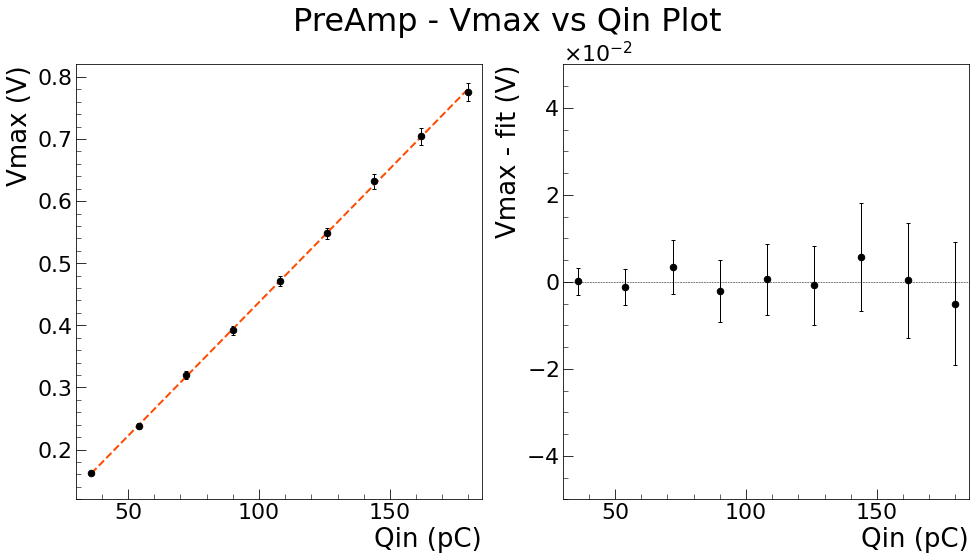

In [77]:
PA.preamp_lin_fit(data)

In [76]:
importlib.reload(PA)

<module 'PreAmp_Analysis_Code' from 'd:\\GitHub\\physics_laboratory_2020_2021\\CATENA ELETTRONICA\\Python\\PreAmp_Analysis_Code.py'>